In [1]:
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from deepmatch.models import *
from deepmatch.utils import sampledsoftmaxloss

DeepCTR version 0.8.4 detected. Your version is 0.8.2.
Use `pip install -U deepctr` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR/releases/tag/v0.8.4


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
import random
import numpy as np
from tqdm import tqdm
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("./data/movielens_sample.txt")
sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip"]
SEQ_LEN = 50
negsample = 3

In [5]:
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [37]:
data.count()

user_id       233
movie_id      233
rating        233
timestamp     233
title         233
genres        233
gender        233
age           233
occupation    233
zip           233
dtype: int64

In [8]:
data["user_id"].value_counts()

2    129
1     53
3     51
Name: user_id, dtype: int64

In [9]:
data.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'title', 'genres',
       'gender', 'age', 'occupation', 'zip'],
      dtype='object')

In [10]:
features = ['user_id', 'movie_id', 'gender', 'age', 'occupation', 'zip']

feature_max_idx = {}
for feature in features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature]) + 1             # 默认编码从0开始
    feature_max_idx[feature] = data[feature].max() + 1               # 作为Embedding向量的大小设定

# 构建用户画像
user_profile = data[["user_id", "gender", "age", "occupation", "zip"]].drop_duplicates('user_id')
user_profile.set_index("user_id", inplace=True)

In [38]:
feature_max_idx

{'user_id': 4,
 'movie_id': 209,
 'gender': 3,
 'age': 4,
 'occupation': 4,
 'zip': 4}

In [11]:
user_profile

,gender,age,occupation,zip
user_id,,,,
1,1,1,1,1
2,2,3,3,3
3,2,2,2,2


In [12]:
# 构建物品画像
item_profile = data[['movie_id']].drop_duplicates('movie_id')

In [13]:
item_profile

,movie_id
0,66
1,39
2,47
3,191
4,147
...,...
228,202
229,169
230,135
231,64


In [14]:
# 用户历史点击文章序列
user_item_list = data.groupby("user_id")['movie_id'].apply(list)

In [15]:
user_item_list

user_id
1    [66, 39, 47, 191, 147, 68, 85, 166, 33, 48, 34...
2    [66, 180, 144, 127, 70, 132, 77, 89, 177, 100,...
3    [147, 68, 84, 126, 11, 183, 37, 71, 80, 168, 2...
Name: movie_id, dtype: object

In [16]:
def gen_data_set(data, negsample=0):
    data.sort_values("timestamp", inplace=True)
    item_ids = data['movie_id'].unique()
    
    train_set = []
    test_set = []
    for reviewerID, hist in tqdm(data.groupby('user_id')):
        pos_list = hist['movie_id'].tolist()
        rating_list = hist['rating'].tolist()
        
        if negsample > 0:
            candidate_set = list(set(item_ids) - set(pos_list))
            neg_list = np.random.choice(candidate_set, size=len(pos_list)*negsample, replace=True)
        for i in range(1, len(pos_list)):
            hist = pos_list[:i]
            if i != len(pos_list)-1:
                train_set.append((reviewerID, hist[::-1], 1, pos_list[i], 1, len(hist[::-1]), rating_list[i]))
                for negi in range(negsample):
                    train_set.append((reviewerID, hist[::-1], neg_list[i*negsample+negi], 0, len(hist[::-1])))
            else:
                test_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1]), rating_list[i]))

    random.shuffle(train_set)
    random.shuffle(test_set)
    
    return train_set, test_set

In [17]:
def gen_model_input(train_set, user_profile, seq_max_len):
    
    train_uid = np.array([line[0] for line in train_set])
    train_seq = [line[1] for line in train_set]
    train_iid = np.array([line[2] for line in train_set])
    train_label = np.array([line[3] for line in train_set])
    train_hist_len = np.array([line[4] for line in train_set])
    
    # 填补缺失值
    train_seq_pad = pad_sequences(train_seq, maxlen=seq_max_len, padding='post', truncating='post', value=0)
    
    # 标签movie_id: 最后一次的点击视频id号
    train_model_input = {'user_id': train_uid, 'movie_id': train_iid, 'hist_movie_id': train_seq_pad, 'hist_len': train_hist_len}
    
    # 添加用户信息
    for key in ["gender", "age", "occupation", "zip"]:
        train_model_input[key] = user_profile.loc[train_model_input['user_id']][key].values
    return train_model_input, train_label

In [19]:
train_set, test_set = gen_data_set(data, negsample)
train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)

100%|██████████| 3/3 [00:00<00:00, 272.71it/s]


In [20]:
train_model_input

{'user_id': array([2, 2, 2, 2, 1, 3, 2, 2, 2, 3, 1, 3, 2, 1, 1, 3, 2, 2, 2, 1, 3, 2,
        1, 1, 3, 1, 2, 1, 1, 1, 2, 2, 2, 3, 1, 2, 2, 1, 3, 3, 3, 3, 1, 2,
        2, 3, 1, 2, 1, 2, 2, 3, 3, 2, 1, 3, 2, 3, 2, 2, 1, 3, 2, 3, 3, 2,
        2, 3, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
        2, 2, 1, 3, 2, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2,
        3, 2, 1, 2, 2, 1, 1, 3, 2, 1, 3, 2, 3, 2, 2, 3, 2, 1, 2, 1, 3, 1,
        3, 2, 2, 1, 3, 2, 1, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2,
        2, 3, 2, 1, 3, 2, 2, 2, 2, 1, 2, 3, 2, 1, 2, 3, 2, 3, 2, 2, 2, 1,
        2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 3, 3, 2, 3, 1, 2, 3, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 2, 1, 3, 3,
        1, 3, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 1, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2,
        1, 2, 2, 2, 3, 3, 2, 1, 1, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2,
        2, 2, 1, 3, 2, 2, 2

In [21]:
embedding_dim = 16
user_feature_columns = [
    SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
    SparseFeat('gender',  feature_max_idx['gender'], embedding_dim),
    SparseFeat('age', feature_max_idx['age'], embedding_dim),
    SparseFeat('occupation', feature_max_idx['occupation'], embedding_dim),
    SparseFeat('zip', feature_max_idx['zip'], embedding_dim),
    VarLenSparseFeat(SparseFeat('hist_movie_id', feature_max_idx['movie_id'], embedding_dim, embedding_name='movie_id'), SEQ_LEN, 'mean', 'hist_len'),
]

item_feature_columns = [SparseFeat('movie_id', feature_max_idx['movie_id'], embedding_dim)]

In [22]:
K.set_learning_phase(True)
import tensorflow as tf
if tf.__version__ >= '2.0.0':
    tf.compat.v1.disable_eager_execution()

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [23]:
model = YoutubeDNN(user_feature_columns, item_feature_columns, num_sampled=5, user_dnn_hidden_units=(64, 16))

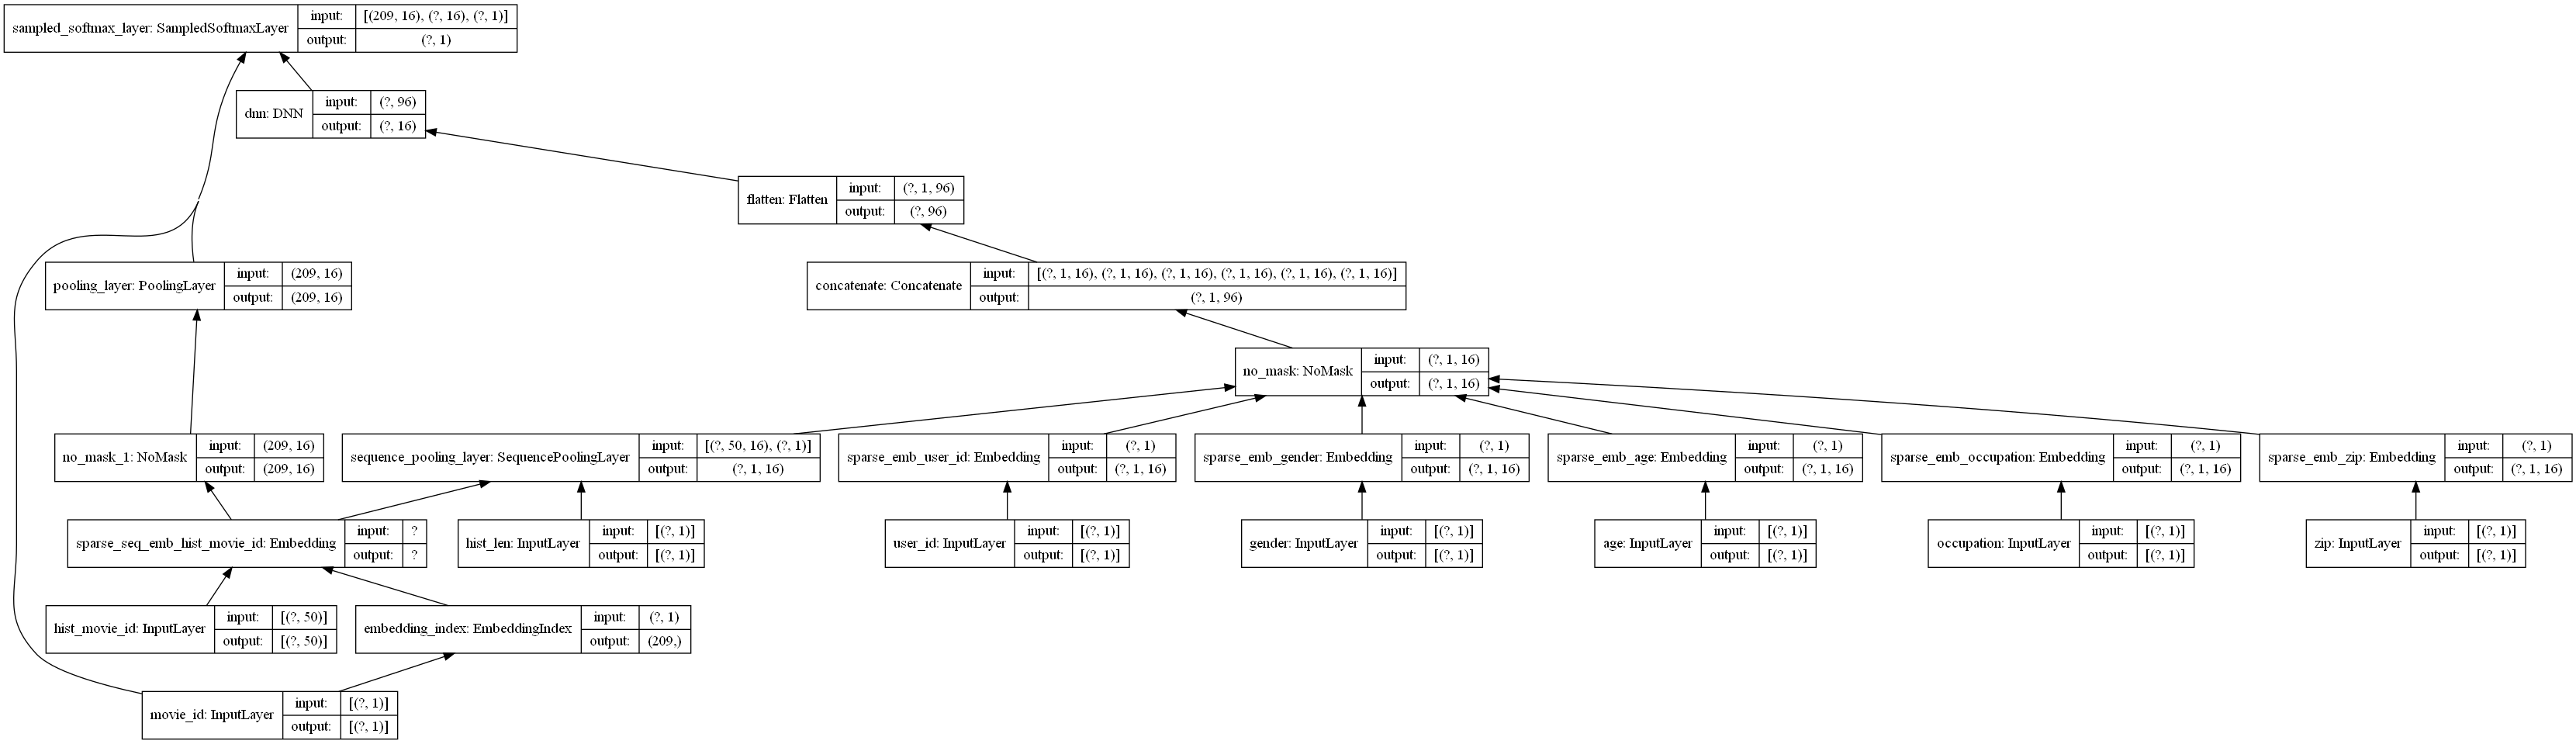

In [26]:
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='BT', to_file='./imgs/model.png')

In [27]:
model.compile(optimizer="adagrad", loss=sampledsoftmaxloss, experimental_run_tf_function=False)    # "binary_crossentropy"

In [28]:
history = model.fit(train_model_input, train_label, batch_size=256, epochs=5, verbose=1, validation_split=0.0,)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 908 samples
Epoch 1/5
908/908 [==============================] - ETA: 0s - loss: 2.490 - 0s 51us/sample - loss: 1.8112
Epoch 2/5
908/908 [==============================] - ETA: 0s - loss: 2.405 - 0s 45us/sample - loss: 2.2810
Epoch 3/5
908/908 [==============================] - ETA: 0s - loss: 2.116 - ETA: 0s - loss: 1.547 - 0s 78us/sample - loss: 1.6280
Epoch 4/5
908/908 [==============================] - ETA: 0s - loss: 1.783 - 0s 44us/sample - loss: 1.9078
Epoch 5/5
908/908 [==============================] - ETA: 0s - loss: 1.919 - 0s 51us/sample - loss: 1.6244


In [29]:
# 测试阶段
test_user_model_input = test_model_input
all_item_model_input = {'movie_id': item_profile['movie_id'].values}

user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)

user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2**12)
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2**12)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [30]:
user_embs.shape

(3, 16)

In [31]:
item_embs.shape

(208, 16)

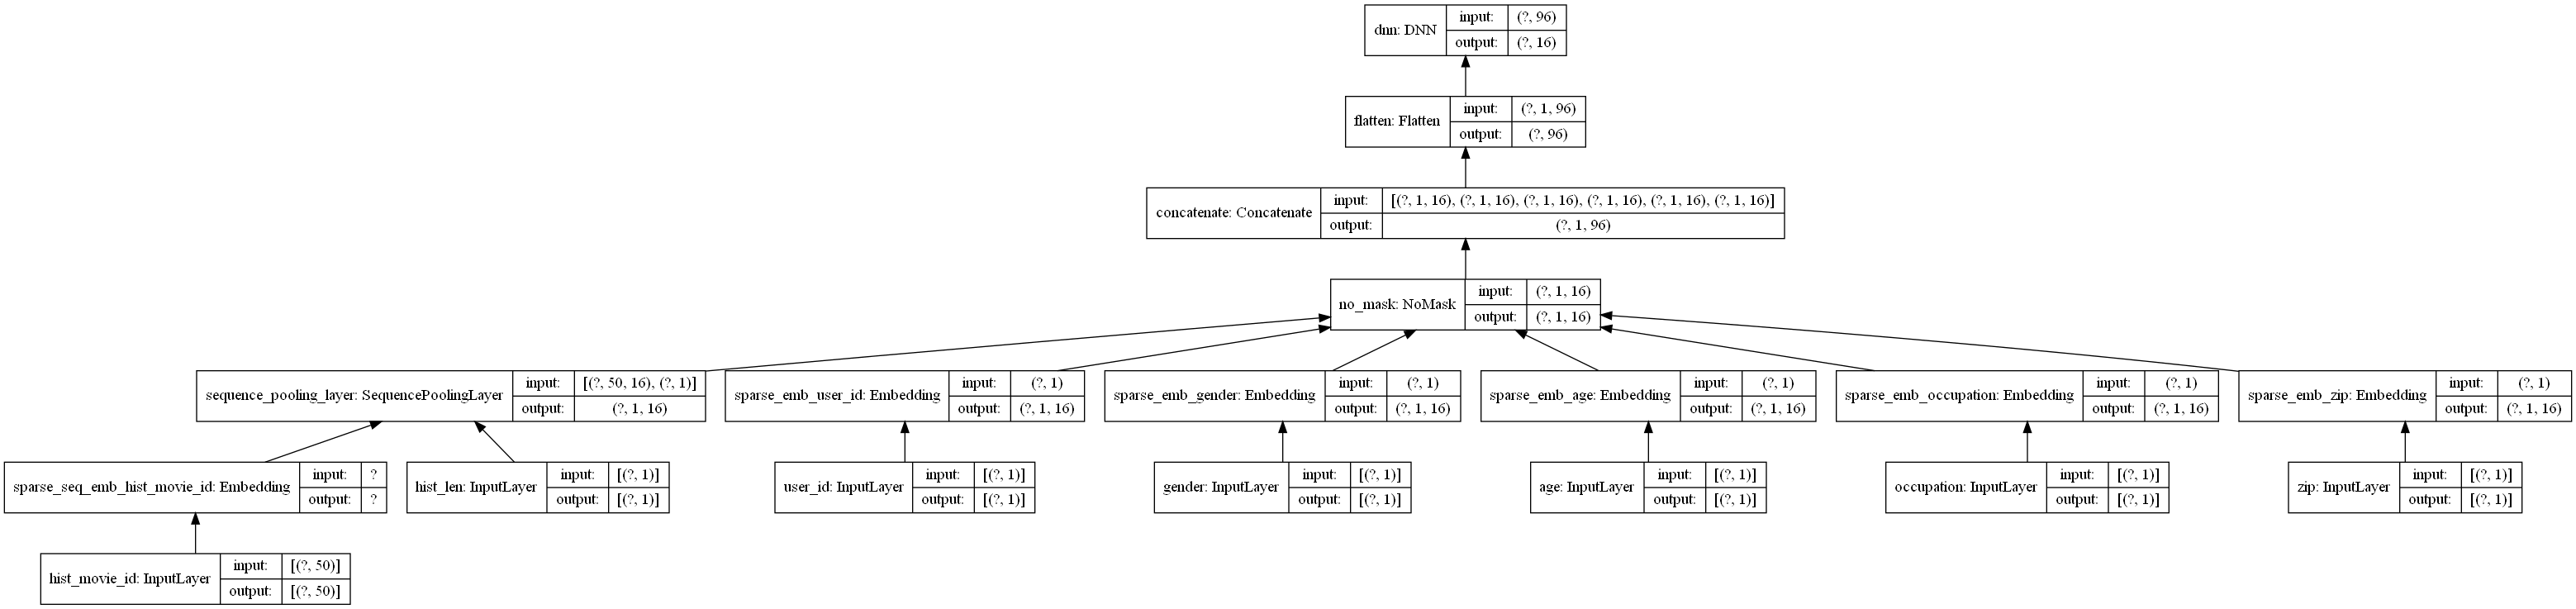

In [32]:
plot_model(user_embedding_model, show_shapes=True, show_layer_names=True, rankdir="BT", to_file="./imgs/dnn.png")

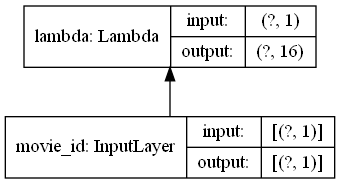

In [33]:
plot_model(item_embedding_model, show_shapes=True, show_layer_names=True, rankdir="BT", to_file="./imgs/emb.png")

In [34]:
test_true_label = {line[0]: [line[2]] for line in test_set}

In [36]:
import numpy as np
import faiss

ImportError: DLL load failed: 找不到指定的模块。

In [ ]:
def YoutubeDNN(user_feature_columns, item_feature_columns, num_sampled=5, 
               user_dnn_hidden_units(64, 32), 
               dnn_activation='relu', dnn_use_bn=False, 
               l2_reg_dnn=0, l2_reg_embedding=1e-6, 
               dnn_dropout=0, output_activation='linear', seed=1024,):
    """Instantiates the YoutubeDNN Model architecture.

    :param user_feature_columns: An iterable containing user's features used by  the model.
    :param item_feature_columns: An iterable containing item's features used by  the model.
    :param num_sampled: int, the number of classes to randomly sample per batch.
    :param user_dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of user tower
    :param dnn_activation: Activation function to use in deep net
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in deep net
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param seed: integer ,to use as random seed.
    :param output_activation: Activation function to use in output layer
    :return: A Keras model instance.
    """
    if len(item_feature_columns) > 1:
        raise ValueError("Now YoutubeNN only support 1 item feature like item_id")
    
    item_feature_name = item_feature_columns[0].name
    item_vacabulary_size = item_feature_columns[0].vocabulary_size
    
    # 为稀疏特征创建对应的Embedding字典
    embedding_matrix_dict = create_embedding_matrix(user_feature_columns + item_feature_columns, l2_reg_embedding, seed=seed)
    
    # 获取用户输入特征
    user_features = build_input_features(user_feature_columns)
    
    user_inputs_list = list(user_)
    